<a href="https://colab.research.google.com/github/xiaossr/68300-final-project/blob/main/clip_attention_mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-pkfq7678
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-pkfq7678
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import clip

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

In [3]:
# 1) Load CLIP ViT-B/32
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
model.eval()

100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 75.7MiB/s]


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [9]:
preprocess = transforms.Compose([
    transforms.Resize(224), transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.481,0.457,0.408),(0.268,0.261,0.275))
])
train_ds = datasets.CIFAR10(root="data", train=True, download=True, transform=preprocess)
test_ds  = datasets.CIFAR10(root="data", train=False, download=True, transform=preprocess)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:04<00:00, 42.3MB/s]


In [10]:
# --- 2) load CLIP ---
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _ = clip.load("ViT-B/32", device=device)
model.eval()

def extract_features(loader, window_mask):
    feats, labels = [], []
    for imgs, ys in loader:
        imgs = imgs.to(device)
        # apply the same mask to every block before forward:
        for blk in model.visual.transformer.resblocks:
            blk.attn.attn_mask = window_mask
        with torch.no_grad():
            z = model.encode_image(imgs)   # [B, 512]
        feats.append(z.cpu().numpy())
        labels.append(ys.numpy())
    return np.concatenate(feats,0), np.concatenate(labels,0)

In [21]:
def build_window_mask(seq_len, grid_size, k):
    M = torch.full((seq_len, seq_len), float("-inf"))
    for i in range(seq_len):
        xi, yi = (0, 0) if i == 0 else divmod(i-1, grid_size)
        for j in range(seq_len):
            xj, yj = (0, 0) if j == 0 else divmod(j-1, grid_size)
            if abs(xi - xj) <= k and abs(yi - yj) <= k:
                M[i, j] = 0.0
    return M

In [15]:
preprocess = transforms.Compose([
    transforms.Resize(224), transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.481,0.457,0.408),(0.268,0.261,0.275))
])
train_ds = datasets.CIFAR10("data", True,  transform=preprocess, download=True)
test_ds  = datasets.CIFAR10("data", False, transform=preprocess, download=True)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False)

device = "cuda" if torch.cuda.is_available() else "cpu"
model, _ = clip.load("ViT-B/32", device=device)
model.eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [26]:
def extract_pooled_patch_features(loader, window_mask):
    # Pull dtype from the very first conv layer
    model_dtype = model.visual.conv1.weight.dtype
    seq_len = window_mask.shape[0]
    grid    = int((seq_len - 1)**0.5)
    all_feats, all_labels = [], []

    # cast mask once, to both device & dtype
    window_mask = window_mask.to(device=device, dtype=model_dtype)

    for imgs, ys in loader:
        # 1) move & cast imgs → same dtype as model (float16 on GPU)
        imgs = imgs.to(device=device, dtype=model_dtype)
        B    = imgs.shape[0]

        # 2) set the mask on every attention block
        for blk in model.visual.transformer.resblocks:
            blk.attn.attn_mask = window_mask

        with torch.no_grad():
            # 3a) patch‐embed conv
            x = model.visual.conv1(imgs)          # [B, C, G, G]
            _, C, G, _ = x.shape

            # 3b) flatten → [B, G², C]
            x = x.reshape(B, C, G*G).permute(0,2,1)

            # 3c) prepend CLS, add pos‐emb
            cls = model.visual.class_embedding.to(x.dtype)           # [C]
            cls = cls.unsqueeze(0).expand(B, -1, -1)                 # [B,1,C]
            x   = torch.cat([cls, x], dim=1)                         # [B,1+G²,C]
            x   = x + model.visual.positional_embedding.to(x.dtype)

            # 3d) transformer (current CLIP returns only the token tensor)
            x = x.permute(1,0,2)                                     # [1+G², B, C]
            x = model.visual.ln_pre(x)
            x = model.visual.transformer(x)                          # [1+G², B, C]
            x = x.permute(1,0,2)                                     # [B, 1+G², C]

            # 3e) drop CLS & mean‐pool patches
            patches = x[:,1:,:]                                      # [B, G², C]
            pooled  = patches.mean(dim=1)                            # [B, C]

        all_feats.append(pooled.cpu().numpy())
        all_labels.append(ys.numpy())

    return np.concatenate(all_feats, axis=0), np.concatenate(all_labels, axis=0)


In [28]:
seq_len, grid = 1 + 7*7, 7
results = {}
for k in [0,1,2,3]:
    M = build_window_mask(seq_len, grid, k).to(device)

    Xtr, ytr = extract_pooled_patch_features(train_loader, M)
    Xte, yte = extract_pooled_patch_features(test_loader,  M)

    clf = LogisticRegression(max_iter=2000).fit(Xtr, ytr)
    acc = accuracy_score(yte, clf.predict(Xte))
    results[k] = acc
    print(f"Window k={k:>2} → test accuracy {acc*100:5.2f}%")

Window k= 0 → test accuracy 93.84%
Window k= 1 → test accuracy 93.77%
Window k= 2 → test accuracy 93.80%
Window k= 3 → test accuracy 93.78%


In [29]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5).fit(Xtr, ytr)
acc_knn = knn.score(Xte, yte)
print(f"kNN accuracy: {acc_knn*100:.2f}%")


kNN accuracy: 89.96%


In [32]:
test_ds = datasets.CIFAR10("data", train=False, download=True, transform=preprocess)
classes = test_ds.classes
prompts = [f"a photo of a {c}" for c in classes]
text_tokens = clip.tokenize(prompts).to(device)
with torch.no_grad():
    text_feats = model.encode_text(text_tokens)      # [10,512]
    text_feats /= text_feats.norm(dim=-1, keepdim=True)

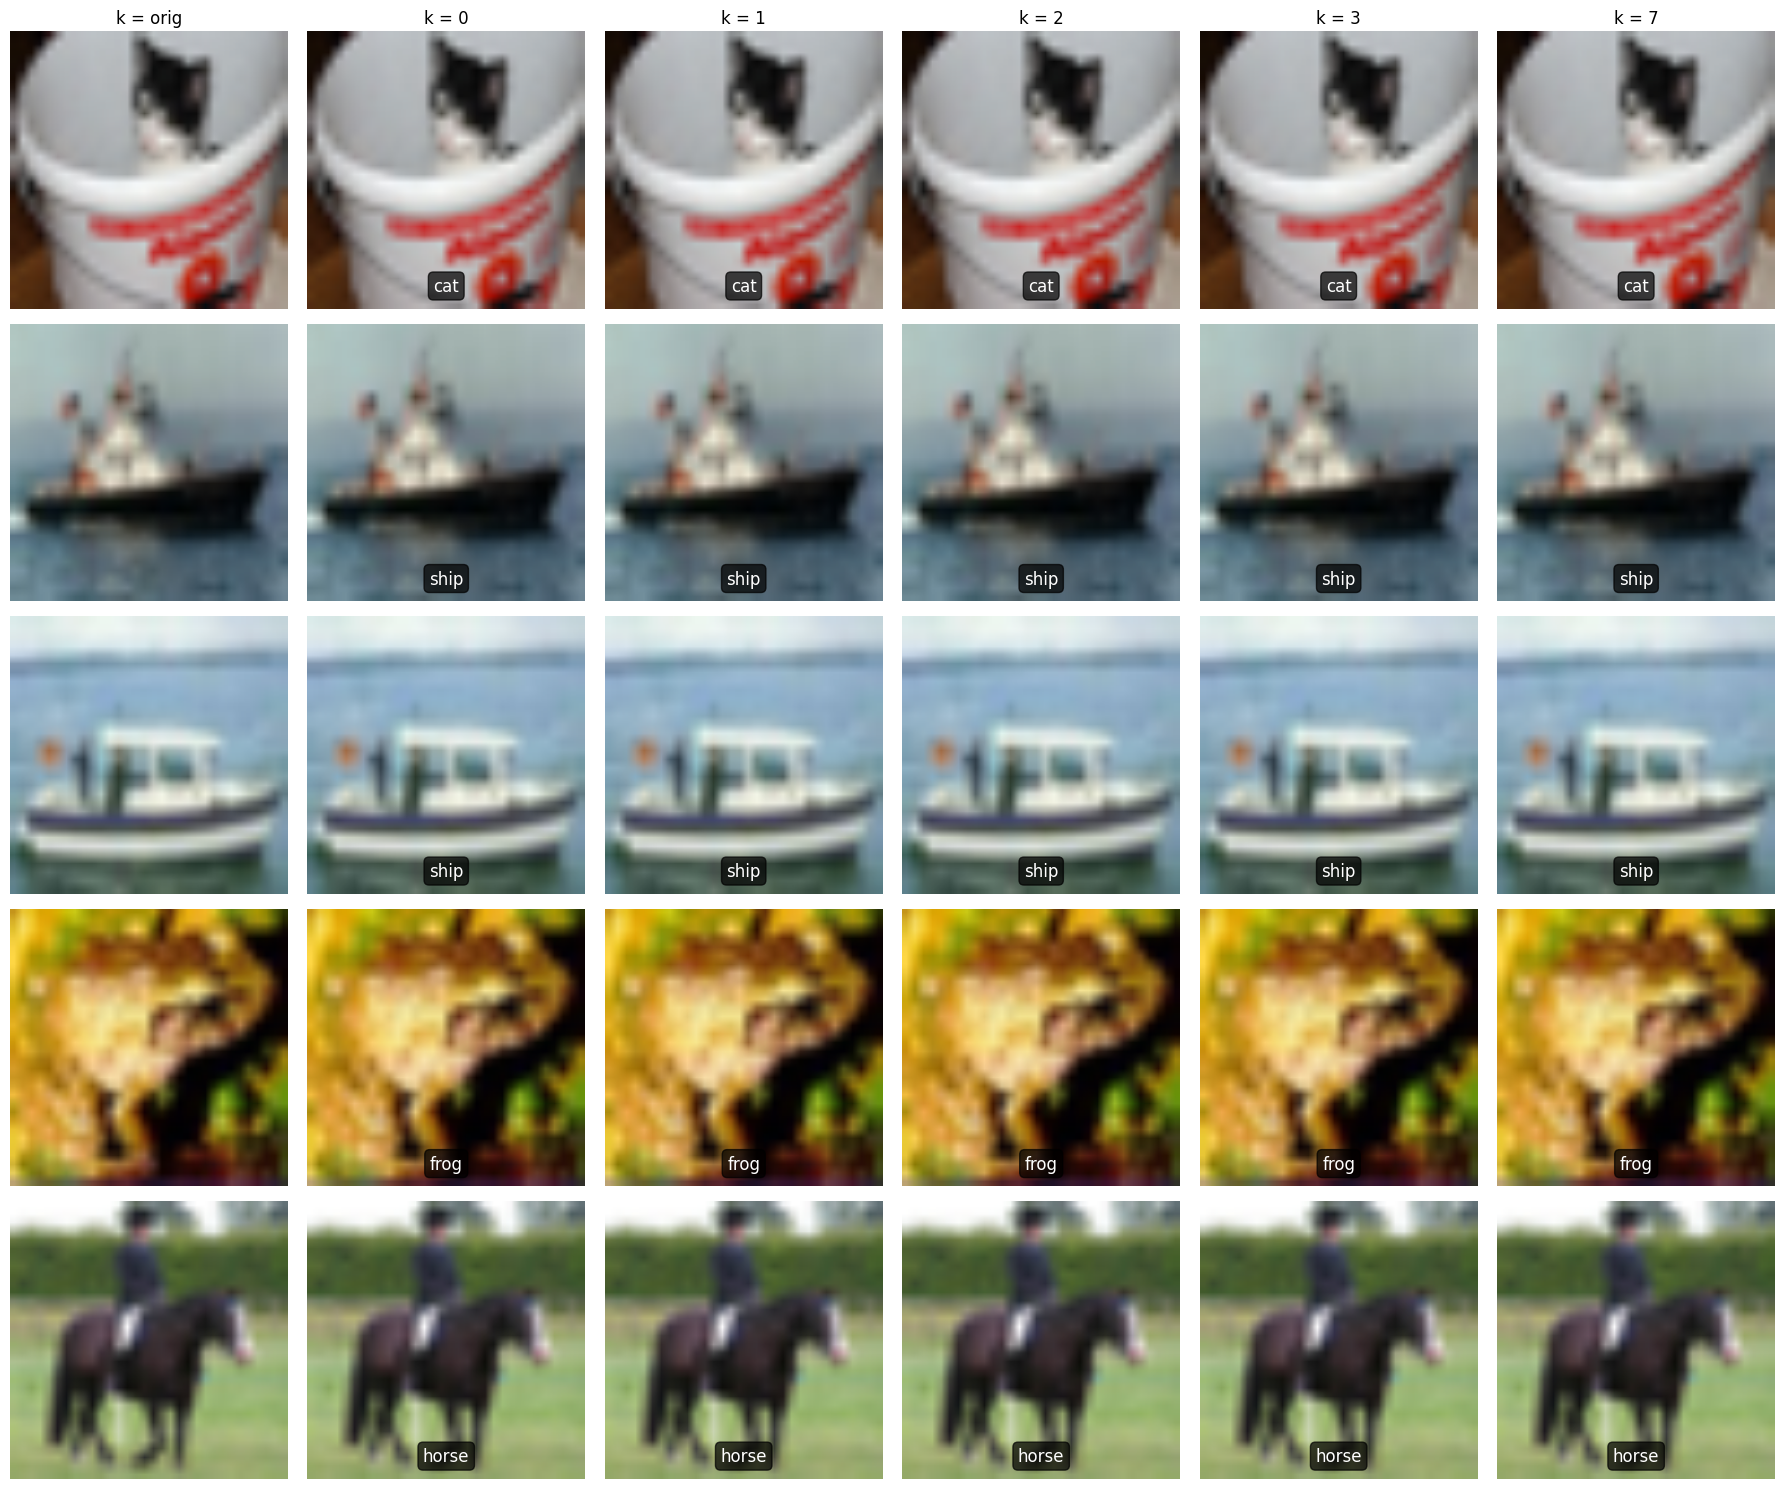

In [35]:
# 3) Grab a small batch of CIFAR-10 test images
test_ds = datasets.CIFAR10("data", train=False, download=True, transform=preprocess)
# pick 5 random indices
idxs = torch.randperm(len(test_ds))[:5]
images, labels = zip(*(test_ds[i] for i in idxs))
imgs = torch.stack(images).to(device)

# 4) For each window‐size k, run each image through masked CLIP & get top-1 text label
seq_len, grid = 1 + 7*7, 7
window_sizes = [0, 1, 2, 3, 7]  # include full-global (7) as baseline
results = {k: [] for k in window_sizes}

for k in window_sizes:
    # build & cast mask
    M = build_window_mask(seq_len, grid, k).to(device)
    # attach to every block
    for blk in model.visual.transformer.resblocks:
        blk.attn.attn_mask = M

    with torch.no_grad():
        # encode all 5 images at once
        img_feats = model.encode_image(imgs)                 # [5,512]
        img_feats /= img_feats.norm(dim=-1, keepdim=True)

        # cosine similarity to each text prompt
        sims = (img_feats @ text_feats.T)                    # [5,10]
        top5 = sims.argmax(dim=-1).cpu().tolist()            # [5]

    # map to class names
    for i in top5:
        results[k].append(classes[i])

# 5) Plot the “transcripts”
inv_norm = transforms.Normalize(
    mean=[-0.481/0.268, -0.457/0.261, -0.408/0.275],
    std=[1/0.268, 1/0.261, 1/0.275]
)

n = len(images)
Ks = ["orig"] + window_sizes
fig, axes = plt.subplots(n, len(Ks), figsize=(3*len(Ks), 3*n))

for i in range(n):
    # precompute the displayable image once
    img_disp = inv_norm(images[i]).clamp(0,1).permute(1,2,0).cpu().numpy()

    for j, k in enumerate(Ks):
        ax = axes[i, j]
        ax.imshow(img_disp)     # draw the image in every column
        ax.axis("off")

        # title row
        if i == 0:
            ax.set_title(f"k = {k}")

        # overlay the transcript for non‐original columns
        if k != "orig":
            lbl = results[k][i]
            ax.text(
                0.5, 0.05, lbl,
                transform=ax.transAxes,
                ha="center", va="bottom",
                fontsize=12,
                color="white",
                bbox=dict(facecolor="black", alpha=0.7, boxstyle="round,pad=0.3")
            )

plt.tight_layout()
plt.show()